## Content Page:
* [Exploratory Data Analysis](#first-bullet)
* [Text Pre-processing and Preparation](#second-bullet)
* [Model Training Section](#third-bullet)
    * [Naive Bayes](#forth-bullet)
    * [Logistic Regression](#fifth-bullet)
    * [Fine Tune Logistic Regression OVR and Multinomial (OVR and Multimonial)](#sixth-bullet)
        * [Fine Tune Logistic Regression OVR](#seventh-bullet)
        * [Fine Tune Logistic Regression Multinomial](#eight-bullet)
        * [Best Logistic Regression Model](#nineth-bullet)
    * [KNN Classifier](#tenth-bullet)
    * [Linear SVC](#eleventh-bullet)
    * [Fine Tuning Linear SVC with GridSearchCV](#12-bullet)
* [Ensemble Methods](#ensemble-bullet)
    * [ADA Boost with logistic regression (best LR from earlier)](#13-bullet)
    * [ADA Boost with Naive Bayes](#14-bullet)
    * [ADA Boost with best Linear SVC](#15-bullet)
    * [Random Forest Classifier](#16-bullet)
    * [Gradient Boosting Classifier](#17-bullet)
    * [Voting Classifier](#18-bullet)
* [Model Selection](#19-bullet)
* [Test on new random data](#20-bullet)


In [1]:
# #install relevant libraries
# !pip install -q transformers
# !pip3 install torch torchvision torchaudio

In [2]:
# # from transformers import pipeline
# # sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment")
# sentiment_pipeline(data)

## Exploratory Data Analysis <a class="anchor" id="first-bullet"></a>

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
from collections import defaultdict
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('tweet_emotions.csv')
df2 = pd.read_csv('Emotion_final.csv')
df3 = pd.read_csv("extra_data.csv", names=["sentiment", "id", 'date',"query", "user", "content"])

In [3]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [4]:
df2.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
df3.head()

,sentiment,id,date,query,user,content
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [6]:
df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [7]:
df2.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [8]:
df3.isnull().sum()

sentiment    0
id           0
date         0
query        0
user         0
content      0
dtype: int64

In [9]:
df.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [10]:
df2.Emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [11]:
df3.sentiment.unique()

array([4, 0, 2], dtype=int64)

In [12]:
def sentiments_df3(val):
    if val==0:
        return 'negative'
    elif val == 2:
        return 'neutral'
    elif val==4:
        return 'positive'

In [13]:
# (0 = negative, 2 = neutral, 4 = positive) based on dataset provider
df3['sentiment'] = df3['sentiment'].apply(sentiments_df3)

In [14]:
df3.sentiment.unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [15]:
df3.drop(['id','date','query','user'], axis=1, inplace=True)

In [16]:
#drop surprise and neutral sentiments
df.drop(df.loc[df['sentiment'] == 'surprise'].index, inplace=True)
df2.drop(df2.loc[df2['Emotion'] == 'surprise'].index, inplace=True)
df.drop(df.loc[df['sentiment'] == 'neutral'].index, inplace=True)
df2.drop(df2.loc[df2['Emotion'] == 'neutral'].index, inplace=True)
df3.drop(df3.loc[df3['sentiment'] == 'neutral'].index, inplace=True)

In [17]:
df2.rename(columns={"Emotion": "sentiment"}, inplace=True)
df2.rename(columns={"Text": "content"}, inplace=True)

In [18]:
merged_df = pd.concat([df, df2,df3])
merged_df.drop('tweet_id', axis=1, inplace=True)

In [19]:
merged_df.groupby('sentiment').count()

,content
sentiment,
anger,3103
boredom,179
empty,827
enthusiasm,759
fear,2652
fun,1776
happiness,5209
happy,7029
hate,1323


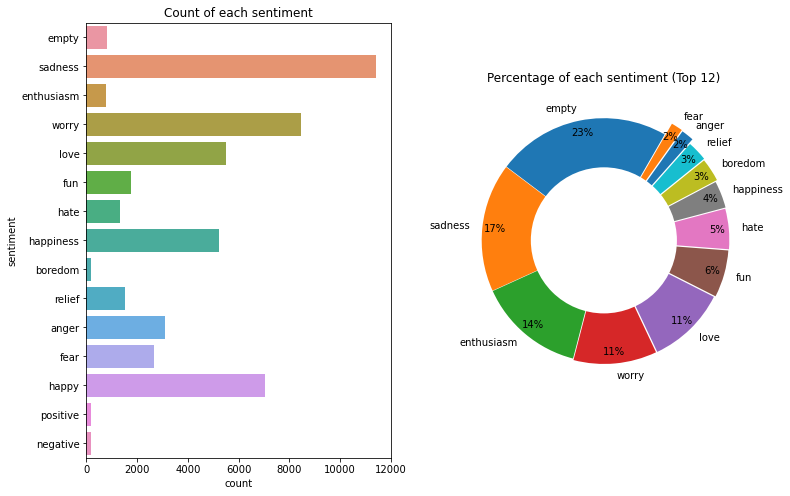

In [55]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(merged_df[col].dropna().value_counts()))/sum(list(merged_df[col].dropna().value_counts())))[::-1])[:12]
labels = list(merged_df[col].dropna().unique())[:12]
sizes = merged_df[col].value_counts()[:12]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = merged_df, ax=ax1)
ax1.set_title("Count of each sentiment")
ax2.set_title("Percentage of each sentiment (Top 12)")
plt.show()

In [56]:
def generalize_sentiment(text):
    if text=='love' or text=='positive' or text=='enthusiasm' or text =='surprise' or text=='fun 'or text=='happy' or text == 'happiness' or text=='relief':
        return 'positive'
    else:
        return 'negative'

In [57]:
merged_df['sentiment'] = merged_df['sentiment'].apply(generalize_sentiment)

In [58]:
merged_df.sentiment.unique()

array(['negative', 'positive'], dtype=object)

<AxesSubplot:>

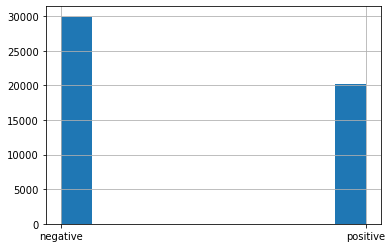

In [59]:
merged_df['sentiment'].hist()

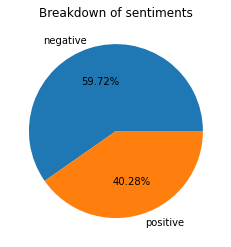

In [60]:
merged_df.groupby('sentiment').size().plot(kind='pie', autopct='%.2f%%')
plt.title("Breakdown of sentiments")
plt.ylabel("")
plt.show()

In [61]:
merged_df['char_length'] = merged_df['content'].apply(lambda x : len(x))
merged_df['token_length'] = merged_df['content'].apply(lambda x : len(x.split(" ")))

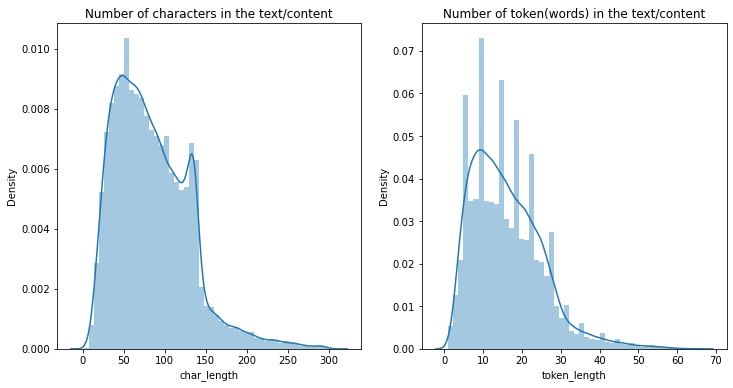

In [62]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(merged_df['char_length'], ax=ax1)
sns.distplot(merged_df['token_length'], ax=ax2)
ax1.set_title('Number of characters in the text/content')
ax2.set_title('Number of token(words) in the text/content')
plt.show()

In [63]:
avg_df = merged_df.groupby('sentiment').agg({'char_length':'mean', 'token_length':'mean'})

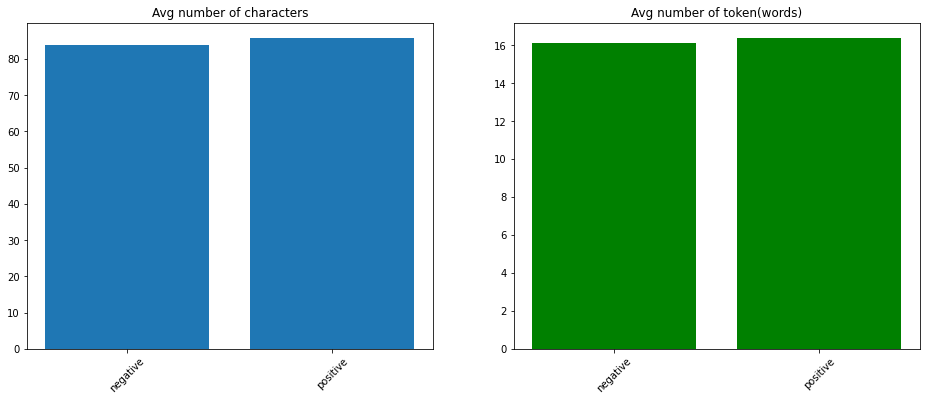

In [64]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['char_length'])
ax2.bar(avg_df.index, avg_df['token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

## Text Pre Processing and Preparation <a class="anchor" id="second-bullet"></a>

In [30]:
# !pip install spacy
# pip install typing-extensions --upgrade
# !pip install nltk
# !pip install inflect
# !pip install contractions

In [65]:
import nltk

In [32]:


# nltk.download('all')
# nltk.download('wordnet')


In [66]:
# Data preparation and text-preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# from nltk.stem import LancasterStemmer, WordNetLemmatizerb
# from nltk.stem import WordNetLemmatizerd
import re
import nltk
import string
import spacy

In [34]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

In [35]:
#### text preprocessing

def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    ## Next step is text-normalization
    
    # Text normalization includes many steps.
    
    # Each function below serves a step.
    
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words
    
    # All above functions work on word tokens we need a tokenizer
    
    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)
    
    
    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]
    
    
    # return processed df
    return df

In [36]:
print("Before Text Preprocessing")
display(merged_df.head()[['content']])
processed_df = text_preprocessing_platform(merged_df, 'content', remove_stopwords=False)
print("After Text Preprocessing")
display(processed_df.head()[['content']])

Before Text Preprocessing


,content
0,@tiffanylue i know i was listenin to bad habi...
1,Layin n bed with a headache ughhhh...waitin o...
2,Funeral ceremony...gloomy friday...
3,wants to hang out with friends SOON!
5,Re-pinging @ghostridah14: why didn't you go to...


/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


After Text Preprocessing


,content
0,tiffanylue know listenin bad habit earlier sta...
1,layin n bed headache ughhhh waitin call
2,funeral ceremony gloomy friday
3,want hang friends soon
5,repinging ghostridah14 go prom bf like friends


In [37]:
# processed_df.tail()

# Prepare for model training (splitting, manual label encoder)

In [38]:
def labelEncode(df):
    if df=='positive':
        return 0
    else:
        return 1
#0 = positive , 1 = negative

In [39]:
y = processed_df['sentiment'].apply(labelEncode)
X = processed_df.iloc[:,1:2]

In [40]:
y.head()

0    1
1    1
2    1
3    0
5    1
Name: sentiment, dtype: int64

In [41]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [42]:
X_train.shape

(40091, 1)

In [43]:
y_test.shape

(10023,)

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
cv = CountVectorizer()

In [46]:
X_train_bow = cv.fit_transform(X_train['content']).toarray()
X_test_bow = cv.transform(X_test['content']).toarray()

In [48]:
import pickle
pickle.dump(cv, open("cv (selected).pickel", "wb"))

## Model Training Section <a class="anchor" id="third-bullet"></a>

## Naive Bayes <a class="anchor" id="forth-bullet"></a>

In [49]:
X_train_bow.shape

(40091, 37127)

In [50]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_bow,y_train)

MultinomialNB()

In [51]:
y_pred = mnb.predict(X_test_bow)
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test,y_pred)

#Confusion Matrix
mnb_tn, mnb_fp, mnb_fn, mnb_tp = confusion_matrix(y_test, y_pred).ravel()

#measurements
mnb_accuracy = (mnb_tp+mnb_tn)/(mnb_tp+mnb_tn+mnb_fp+mnb_fn)
print(" Accuracy", mnb_accuracy)
mnb_precision = mnb_tp/(mnb_tp+mnb_fp)
mnb_recall = mnb_tp/(mnb_tp+mnb_fn)
mnb_f1_score = (2*mnb_precision)*(mnb_recall)/(mnb_precision+mnb_recall)
print(" Precision",mnb_precision,"\n","Recall",mnb_recall,"\n","F1",mnb_f1_score)

 Accuracy 0.8042502244836875
 Precision 0.80406852248394 
 Recall 0.8853149208487706 
 F1 0.8427380570695736


Gentle reminder that we want precision to be high, because if we detect a negative video as positive, the consequences is disastrous. Imagine showing a children a suicide video that was mis-classified as positive.

## Logistic Regression (OVR and Multimonial)  <a class="anchor" id="fifth-bullet"></a>

In [207]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='ovr', C=1)
lr.fit(X_train_bow,y_train)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=1, multi_class='ovr')

In [209]:
#ovr
from sklearn.metrics import accuracy_score,confusion_matrix
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))

#Confusion Matrix
lr_ovr_tn, lr_ovr_fp, lr_ovr_fn, lr_ovr_tp = confusion_matrix(y_test, y_pred).ravel()

#measurements
lr_ovr_accuracy = (lr_ovr_tp+lr_ovr_tn)/(lr_ovr_tp+lr_ovr_tn+lr_ovr_fp+lr_ovr_fn)
print(" Accuracy", lr_ovr_accuracy)
lr_ovr_precision = lr_ovr_tp/(lr_ovr_tp+lr_ovr_fp)
lr_ovr_recall = lr_ovr_tp/(lr_ovr_tp+lr_ovr_fn)
lr_ovr_f1_score = (2*lr_ovr_precision)*(lr_ovr_recall)/(lr_ovr_precision+lr_ovr_recall)
print(" Precision",lr_ovr_precision,"\n","Recall",lr_ovr_recall,"\n","F1",lr_ovr_f1_score)

0.8213109847351092
 Accuracy 0.8213109847351092
 Precision 0.8272053021934669 
 Recall 0.8827888177837656 
 F1 0.8540936863543788


In [210]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial', C=1)
lr.fit(X_train_bow,y_train)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=1, multi_class='multinomial')

In [213]:
#multinomial
from sklearn.metrics import accuracy_score,confusion_matrix
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))

#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()

#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8173201636236656
 Accuracy 0.8173201636236656
 Precision 0.8276687410244136 
 Recall 0.873526439878747 
 F1 0.8499795165915607


In [214]:
metric_data = [["Logistic Regression (OVR)", lr_ovr_accuracy, lr_ovr_precision, lr_ovr_recall, lr_ovr_f1_score], ["Logistic Regression (Multinomial)", lr_mn_accuracy, lr_mn_precision, lr_mn_recall, lr_mn_f1_score], ["Multinomial Naive Bayes", mnb_accuracy, mnb_precision, mnb_recall, mnb_f1_score]]
res_df = pd.DataFrame(metric_data, columns=['Classifier', 'Accuracy Score', 'Precision', 'Recall', 'F-Measure'])
res_df

,Classifier,Accuracy Score,Precision,Recall,F-Measure
0,Logistic Regression (OVR),0.821311,0.827205,0.882789,0.854094
1,Logistic Regression (Multinomial),0.817320,0.827669,0.873526,0.849980
2,Multinomial Naive Bayes,0.804250,0.804069,0.885315,0.842738


# Save models trained for NB one. We will tune the LR models later (As of Proposal)

In [220]:
import pickle
# save the model to disk
filename = 'multinomialNB.pkl'
pickle.dump(mnb, open(filename, 'wb'))

In [221]:
import gc
del mnb
gc.collect()

11942

## Fine Tune Logistic Regression OVR and Multinomial (OVR and Multimonial)  <a class="anchor" id="sixth-bullet"></a>

## Fine Tune OVR <a class="anchor" id="seventh-bullet"></a>

In [222]:
lr = LogisticRegression(multi_class='ovr', C=0.01)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.7269280654494662
 Accuracy 0.7269280654494662
 Precision 0.7033413797484437 
 Recall 0.9323004378578647 
 F1 0.8017959301904555


In [223]:
lr = LogisticRegression(multi_class='ovr', C=0.1)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8152249825401576
 Accuracy 0.8152249825401576
 Precision 0.8074029491423412 
 Recall 0.9036712697878073 
 F1 0.8528289891926255


In [224]:
lr = LogisticRegression(multi_class='ovr', C=0.15)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8197146562905318
 Accuracy 0.8197146562905318
 Precision 0.8142400730260155 
 Recall 0.9013135735938026 
 F1 0.8555671009511631


In [225]:
lr = LogisticRegression(multi_class='ovr', C=0.2)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8217100668462536
 Accuracy 0.8217100668462536
 Precision 0.817986823962004 
 Recall 0.8991242842707983 
 F1 0.8566385880465301


In [226]:
lr = LogisticRegression(multi_class='ovr', C=0.5)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8228075426519006
 Accuracy 0.8228075426519006
 Precision 0.8247503121098627 
 Recall 0.8900303132367801 
 F1 0.8561477401587559


In [227]:
lr = LogisticRegression(multi_class='ovr', C=0.6)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8226080015963284
 Accuracy 0.8226080015963284
 Precision 0.8256105197244834 
 Recall 0.8881778376557764 
 F1 0.8557520687976635


In [228]:
lr = LogisticRegression(multi_class='ovr', C=0.7)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8215105257906814
 Accuracy 0.8215105257906814
 Precision 0.8255138867095559 
 Recall 0.885988548332772 
 F1 0.854682803996426


In [229]:
lr = LogisticRegression(multi_class='ovr', C=0.8)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8213109847351092
 Accuracy 0.8213109847351092
 Precision 0.8264840182648402 
 Recall 0.8839676658807679 
 F1 0.8542599072341118


In [230]:
lr = LogisticRegression(multi_class='ovr', C=0.9)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8218098373740397
 Accuracy 0.8218098373740397
 Precision 0.8272383354350568 
 Recall 0.8837992590097676 
 F1 0.8545839439830646


# Logistic Regression OVR with c=0.2 is the best so far, with F1 of 0.8566385880465301

## Fine Tune Multinomial <a class="anchor" id="eight-bullet"></a>

In [232]:
lr = LogisticRegression(multi_class='multinomial', C=0.01)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.7640427017858924
 Accuracy 0.7640427017858924
 Precision 0.7421716144774299 
 Recall 0.922027618726844 
 F1 0.82238077356365


In [233]:
lr = LogisticRegression(multi_class='multinomial', C=0.1)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8217100668462536
 Accuracy 0.8217100668462536
 Precision 0.817986823962004 
 Recall 0.8991242842707983 
 F1 0.8566385880465301


In [234]:
lr = LogisticRegression(multi_class='multinomial', C=0.15)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8224084605407562
 Accuracy 0.8224084605407562
 Precision 0.821229913473424 
 Recall 0.8950825193667902 
 F1 0.8565672844480259


In [235]:
lr = LogisticRegression(multi_class='multinomial', C=0.2)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8231068542352589
 Accuracy 0.8231068542352589
 Precision 0.8242254398256267 
 Recall 0.891545975075783 
 F1 0.8565650028314861


In [236]:
lr = LogisticRegression(multi_class='multinomial', C=0.5)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8218098373740397
 Accuracy 0.8218098373740397
 Precision 0.8277549731607199 
 Recall 0.8829572246547659 
 F1 0.8544654498044328


In [237]:
# import pickle
# # save the model to disk
# filename = 'best logistic_regression-multinomial-c0.5.pkl'
# pickle.dump(lr, open(filename, 'wb'))

In [238]:
lr = LogisticRegression(multi_class='multinomial', C=0.6)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8210116731517509
 Accuracy 0.8210116731517509
 Precision 0.8285759594037425 
 Recall 0.8799259009767598 
 F1 0.8534792551453774


In [239]:
lr = LogisticRegression(multi_class='multinomial', C=0.7)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8213109847351092
 Accuracy 0.8213109847351092
 Precision 0.8294930875576036 
 Recall 0.8790838666217582 
 F1 0.8535688005886681


In [240]:
# import pickle
# # save the model to disk
# filename = 'best logistic_regression-multinomial-c0.7.pkl'
# pickle.dump(lr, open(filename, 'wb'))

In [241]:
lr = LogisticRegression(multi_class='multinomial', C=0.8)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8196148857627457
 Accuracy 0.8196148857627457
 Precision 0.8286123488224061 
 Recall 0.8768945772987538 
 F1 0.8520700376370479


In [242]:
lr = LogisticRegression(multi_class='multinomial', C=0.9)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.818916492068243
 Accuracy 0.818916492068243
 Precision 0.829050279329609 
 Recall 0.8747052879757494 
 F1 0.8512660821109563


## Best Logistic Regression Model <a class="anchor" id="nineth-bullet"></a>

## Up till here, Logistic Regression OVR with c=0.2 is still the best so far, with F1 of 0.8566385880465301. We will now train it and save it as our best logistic regression model


In [243]:
lr = LogisticRegression(multi_class='ovr', C=0.2)
lr.fit(X_train_bow,y_train)
y_pred = lr.predict(X_test_bow)
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8217100668462536
 Accuracy 0.8217100668462536
 Precision 0.817986823962004 
 Recall 0.8991242842707983 
 F1 0.8566385880465301


In [244]:
import pickle
# save the model to disk
filename = 'BEST LR OVR C0.2.pkl'
pickle.dump(lr, open(filename, 'wb'))

## KNN Classifier <a class="anchor" id="tenth-bullet"></a>

KNN takes very long to predict and give lower score, hence we will not be using K-NN even thought its F1 Score is not bad

In [245]:
from sklearn.neighbors import KNeighborsClassifier

In [246]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_bow, y_train)
y_pred = neigh.predict(X_test_bow)

In [247]:
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.7228374738102364
 Accuracy 0.7228374738102364
 Precision 0.7274690469334869 
 Recall 0.8509599191647019 
 F1 0.7843837317603229


## Linear SVC <a class="anchor" id="eleventh-bullet"></a>

In [248]:
from sklearn.svm import LinearSVC

In [249]:
clf=LinearSVC(random_state=0)
clf.fit(X_train_bow, y_train)

LinearSVC(random_state=0)

In [250]:
y_pred = clf.predict(X_test_bow)
y_pred
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8041504539559015
 Accuracy 0.8041504539559015
 Precision 0.8232232883395674 
 Recall 0.8524755810037049 
 F1 0.8375941093737073


## Fine Tuning Linear SVC with GridSearchCV <a class="anchor" id="12-bullet"></a>

In [251]:
from sklearn.model_selection import GridSearchCV

In [252]:
param_grid = {'C':[0.0001, 0.001, 0.01, 0.02, 0.1,0.15,0.2,0.3,0,4, 0.5, 1.0]}
linearSVC = GridSearchCV(LinearSVC(random_state=0, max_iter=50000),param_grid,cv=5,return_train_score=True)
linearSVC.fit(X_train_bow, y_train)

/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/common/home/projectgrps/IS460/IS460G1/jupyterlab-venv/li

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=50000, random_state=0),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.02, 0.1, 0.15, 0.2, 0.3,
                               0, 4, 0.5, 1.0]},
             return_train_score=True)

In [253]:
#0.1 is the best
print(linearSVC.best_params_)

{'C': 0.1}


In [254]:
clf=LinearSVC(random_state=0,C=0.1, max_iter=50000)
clf.fit(X_train_bow, y_train)

LinearSVC(C=0.1, max_iter=50000, random_state=0)

In [255]:
y_pred = clf.predict(X_test_bow)
y_pred
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8212112142073231
 Accuracy 0.8212112142073231
 Precision 0.8265595463137996 
 Recall 0.8836308521387672 
 F1 0.8541429269086764


# Can we improve even more? Let's try the numbers around 0.1

In [256]:
param_grid = {'C':[0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]}
linearSVC = GridSearchCV(LinearSVC(random_state=0, max_iter=50000),param_grid,cv=5,return_train_score=True)
linearSVC.fit(X_train_bow, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=50000, random_state=0),
             param_grid={'C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12,
                               0.13, 0.14, 0.15]},
             return_train_score=True)

In [258]:
#0.1 is the best
print(linearSVC.best_params_)

{'C': 0.06}


In [259]:
clf=LinearSVC(random_state=0,C=0.06, max_iter=50000)
clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
y_pred
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8234061658186171
 Accuracy 0.8234061658186171
 Precision 0.8251170046801872 
 Recall 0.8907039407207814 
 F1 0.8566569484936832


# Can we improve even more? Let's try the numbers around 0.06

In [260]:
param_grid = {'C':[0.06,0.055,0.065]}
linearSVC = GridSearchCV(LinearSVC(random_state=0, max_iter=50000),param_grid,cv=5,return_train_score=True)
linearSVC.fit(X_train_bow, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=50000, random_state=0),
             param_grid={'C': [0.06, 0.055, 0.065]}, return_train_score=True)

In [261]:
#0.1 is the best
print(linearSVC.best_params_)

{'C': 0.055}


In [262]:
clf=LinearSVC(random_state=0,C=0.055, max_iter=50000)
clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
y_pred
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8239050184575476
 Accuracy 0.8239050184575476
 Precision 0.8250506309393987 
 Recall 0.8918827888177837 
 F1 0.8571659787974427


In [263]:
import pickle
# save the model to disk
filename = 'best SVC (selected model).pkl'
pickle.dump(clf, open(filename, 'wb'))

We will stop here

## Ensemble Methods <a class="anchor" id="ensemble-bullet"></a>

## ADA Boost with logistic regression (best LR from earlier) <a class="anchor" id="13-bullet"></a>

In [264]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
clf = AdaBoostClassifier(base_estimator=LogisticRegression(multi_class='ovr', C=0.2),n_estimators=100, random_state=0)
clf.fit(X_train_bow, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(C=0.2, multi_class='ovr'),
                   n_estimators=100, random_state=0)

In [265]:
from sklearn.metrics import accuracy_score,confusion_matrix
y_pred = clf.predict(X_test_bow)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [266]:
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.6117928763843161
 Accuracy 0.6117928763843161
 Precision 0.6048990468381674 
 Recall 0.9939373526439879 
 F1 0.7520866517999362


## ADA Boost with Naive Bayes <a class="anchor" id="14-bullet"></a>

In [62]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
clf = AdaBoostClassifier(base_estimator=MultinomialNB(),n_estimators=100, random_state=0)
clf.fit(X_train_bow, y_train)

AdaBoostClassifier(base_estimator=MultinomialNB(), n_estimators=100,
                   random_state=0)

In [63]:
from sklearn.metrics import accuracy_score,confusion_matrix
y_pred = clf.predict(X_test_bow)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [64]:
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.699590940836077
 Accuracy 0.699590940836077
 Precision 0.6797690701388036 
 Recall 0.931963624115864 
 F1 0.786135378933163


## ADA Boost with Best Linear SVC <a class="anchor" id="15-bullet"></a>

In [68]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
clf = AdaBoostClassifier(algorithm='SAMME',base_estimator=LinearSVC(random_state=0,C=0.055, max_iter=50000),n_estimators=100, random_state=0)
clf.fit(X_train_bow, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=LinearSVC(C=0.055, max_iter=50000,
                                            random_state=0),
                   n_estimators=100, random_state=0)

In [69]:
from sklearn.metrics import accuracy_score,confusion_matrix
y_pred = clf.predict(X_test_bow)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [70]:
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.7886860221490571
 Accuracy 0.7886860221490571
 Precision 0.8200402144772118 
 Recall 0.8241832266756484 
 F1 0.8221065009239038


# All ada boost model does not outperform base classifier

## Random Forest Classifier <a class="anchor" id="16-bullet"></a>

In [267]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)

In [268]:
clf.fit(X_train_bow, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [269]:
y_pred = clf.predict(X_test_bow)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [271]:
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.5925371645216003
 Accuracy 0.5925371645216003
 Precision 0.5924965076830971 
 Recall 1.0 
 F1 0.744110275689223


In [272]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [273]:
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.5996208719944128
 Accuracy 0.5996208719944128
 Precision 0.5968602193821073 
 Recall 0.9988211519029977 
 F1 0.7472125984251969


In [274]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
y_pred
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.7762147061757957
 Accuracy 0.7762147061757957
 Precision 0.7449290733130054 
 Recall 0.9462782081508926 
 F1 0.8336176841480603


In [275]:
import pickle
# save the model to disk
filename = 'best RF.pkl'
pickle.dump(clf, open(filename, 'wb'))

## GradientBoostingClassifier <a class="anchor" id="17-bullet"></a>

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

In [55]:
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train_bow, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=10,
                           random_state=0)

In [56]:
y_pred = clf.predict(X_test_bow)
y_pred
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.658385712860421
 Accuracy 0.658385712860421
 Precision 0.6491103202846975 
 Recall 0.9215223981138431 
 F1 0.7616926503340758


In [57]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
y_pred
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.7642422428414646
 Accuracy 0.7642422428414646
 Precision 0.7482983747742742 
 Recall 0.9072078140788145 
 F1 0.8201263606607293


In [58]:
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
y_pred
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.798164222288736
 Accuracy 0.798164222288736
 Precision 0.7917722462363989 
 Recall 0.8945772987537891 
 F1 0.8400411164703091


In [59]:
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=1, random_state=0)
clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [60]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.8105357677342113
 Accuracy 0.8105357677342113
 Precision 0.8029098545072746 
 Recall 0.901481980464803 
 F1 0.849345497818326


In [61]:
import pickle
# save the model to disk
filename = 'best GBC.pkl'
pickle.dump(clf, open(filename, 'wb'))

# What if use all our best models to do a voting? Minimum 80 accuracy

## Voting Classifier <a class="anchor" id="18-bullet"></a>

In [49]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [55]:
eclf = VotingClassifier(estimators=[('clf', GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=1, random_state=0)), ('nb', MultinomialNB()), ('lr1', LogisticRegression(multi_class='ovr', C=0.2)),  ('svc', LinearSVC(random_state=0,C=0.055, max_iter=50000)),('rfc',RandomForestClassifier(max_depth=100, random_state=0))])

In [56]:
eclf.fit(X_train_bow, y_train)

VotingClassifier(estimators=[('clf',
                              GradientBoostingClassifier(learning_rate=1.0,
                                                         max_depth=1,
                                                         n_estimators=300,
                                                         random_state=0)),
                             ('nb', MultinomialNB()),
                             ('lr1',
                              LogisticRegression(C=0.2, multi_class='ovr')),
                             ('svc',
                              LinearSVC(C=0.055, max_iter=50000,
                                        random_state=0)),
                             ('rfc',
                              RandomForestClassifier(max_depth=100,
                                                     random_state=0))])

In [57]:
y_pred = eclf.predict(X_test_bow)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [58]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(accuracy_score(y_test,y_pred))
#Confusion Matrix
lr_mn_tn, lr_mn_fp, lr_mn_fn, lr_mn_tp = confusion_matrix(y_test, y_pred).ravel()
#measurements
lr_mn_accuracy = (lr_mn_tp+lr_mn_tn)/(lr_mn_tp+lr_mn_tn+lr_mn_fp+lr_mn_fn)
print(" Accuracy", lr_mn_accuracy)
lr_mn_precision = lr_mn_tp/(lr_mn_tp+lr_mn_fp)
lr_mn_recall = lr_mn_tp/(lr_mn_tp+lr_mn_fn)
lr_mn_f1_score = (2*lr_mn_precision)*(lr_mn_recall)/(lr_mn_precision+lr_mn_recall)
print(" Precision",lr_mn_precision,"\n","Recall",lr_mn_recall,"\n","F1",lr_mn_f1_score)

0.823306395290831
 Accuracy 0.823306395290831
 Precision 0.8130728775356875 
 Recall 0.9112495789828226 
 F1 0.859366314619233


In [60]:
import pickle
# save the model to disk
filename = 'best ensemble.pkl'
pickle.dump(eclf, open(filename, 'wb'))

## Model Selection <a class="anchor" id="19-bullet"></a>

<b> So far our best model (in terms of f1) (Voting Classifier)  </b> <br>
 Accuracy 0.823306395290831 <Br>
 Precision 0.8130728775356875  <Br>
 Recall 0.9112495789828226  <Br>
 F1 0.859366314619233

<b> Our second best model (in terms of f1) (Linear SVC) comes very close, having  </b> <br>
Accuracy 0.8239050184575476 <br>
 Precision 0.8250506309393987 <br>
 Recall 0.8918827888177837 <br>
 F1 0.8571659787974427

<b> Quick Calculation </b><br>
 A quick calculation tell us that our Voting Clasisfier model has  <b>0.002 F1 score higher </b>than our Linear SVC model. <br>
 Our Linear SVC model has  <b> 0.01 precision higher  </b>than our Voting Classifier model.
 
<b> Our team decided to go with Linear SVC, the model with LOWER F1-score but HIGHER Precision </b> <br>
    With F1 score of only 0.002 difference, we went with the Linear SVC that has a high precision, as explained below.
 
As we learnt in class, when False Positive is costly, we look at precision. In our problem, False Positive is costly, because if we show children a negative video that is mis-labelled as positive, the consequences can be severe. Hence, given that F1 score difference is 0.002 but the Precision difference is 0.01, our team decided to go with the model with slightly lower F1 score but higher Precision.

<b> Another Reason: Occam's Razor </b> <br>
In addition, according to Occam's Razor (the Law of Briefness), given two models of similar generalization error/capability, we should use the simpler model over the more complex model, which in this case is Linear SVC as compared to Voting Classifier which uses several models combined into one. 
  <br>  
    
In short, we will <b> sacrifice 0.002 reduction in F1 score for 0.01 gain in precision </b> due to the use case  of our project, as well as LinearSVC is simpler and produce results of similar quality.

# Import saved models and test our work

## Testing on new random data <a class="anchor" id="20-bullet"></a>

We need to run these minimally when we are testing new data from our existing models

In [4]:
# load the model from disk
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.feature_extraction.text import CountVectorizer
best_model = pickle.load(open('best SVC (selected model).pkl', 'rb'))
cv = pickle.load(open('cv (selected).pickel', 'rb')) 

In [5]:
def results(result):
    if result[0]==0:
        return 'positive'
    if result[0]==1:
        return 'negative'

In [48]:
text=["I am glad that I took Machine Learning"]
new_data=  pd.Series(text, copy=False)

In [49]:
X_test_bow = cv.transform(new_data).toarray()

In [50]:
result = best_model.predict(X_test_bow)

In [51]:
print(results(result))

positive


In [52]:
text=["Unfortunately, I failed my machine learning exams"]
new_data=  pd.Series(text, copy=False)

In [53]:
X_test_bow = cv.transform(new_data).toarray()
result = best_model.predict(X_test_bow)

In [54]:
print(results(result))

negative
